In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import stats
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
import torch
import traceback
import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style

In [2]:
style.set_style()

# load results from a directory

In [3]:
pids = ['07665771801545027002', '02525248103113075187', '32636025554843714410', '38245787251624664824', '46234122667175750703', '62763152621276080508'] # adam
pids = pids + ['24656068102223723425', '14386533057886384414', '25613512580747676101', '37442848811462506011', '43736124262873226088', '73633767302574872046'] # sgd
def check_pid(pids, fname):
    for pid in pids:
        if pid in fname:
            return True
    return False

# good for 512
pid_a = '07665771801545027002'
pid_s = '24656068102223723425'

# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new'
out_dir2 = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new2'
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir) if check_pid(pids, fname)]) + \
         sorted([oj(out_dir2, fname) for fname in os.listdir(out_dir2) if check_pid(pids, fname)])

# weights
fnames_w = [fname for fname in fnames if 'weights' in fname]
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames_w)]
rw = pd.concat(results_list, axis=1).T.infer_objects()

# # normal results
fnames_acc = [fname for fname in fnames if '/pid' in fname] # normal results
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames_acc)]
r = pd.concat(results_list, axis=1).T.infer_objects()
its, ts, r = process_results(r)

# # get individual weights
# # rw_sgd = rw[rw.optimizer == 'sgd'].reset_index().iloc[0]
# # rw_adam = rw[rw.optimizer == 'adam'].reset_index().iloc[0]
rw_sgd = rw[rw.pid == pid_s].reset_index().iloc[0]
rw_adam = rw[rw.pid == pid_a].reset_index().iloc[0]


# # get accs
r_sgd = r[r.optimizer == 'sgd'].reset_index().iloc[0]
r_adam = r[r.optimizer == 'adam'].reset_index().iloc[0]

end loop (10, 68)


In [4]:
epoch = int(max(ts))
print('epoch', epoch, r_sgd.max_test_acc, r_adam.max_test_acc, r_sgd.max_train_acc, r_adam.max_train_acc)
print('sgd', r_sgd.accs_train[its == epoch], r_sgd.accs_test[its == epoch], r_sgd.seed)
print('adam', r_adam.accs_train[its == epoch], r_adam.accs_test[its == epoch], r_adam.seed)

epoch 111 0.971 0.9729 0.9999 0.9998166666666667
sgd [0.9999] [0.9704] 5
adam [0.99743333] [0.9703] 4


# prediction-level plots

In [5]:
# get data
def get_data(run):
    train_loader, test_loader = data.get_data_loaders(run)
    X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader)
    return X_train, Y_train, X_test, Y_test

def get_preds(runs, X):
    preds = {}
    for run in tqdm(runs):
        try:
            # load in weights
            model = data.get_model(run)
            weights_dict_dict = run['weights'] # keys are epochs, vals are dicts of all weights
            weights_dict = weights_dict_dict[epoch] # keys are layers, vals are weight values    
            weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict.items()}
            model.load_state_dict(weights_dict_tensors)
            model = model.cuda()
            preds[(run.optimizer, run.seed)] = model(X).cpu()
        except:
            print('skipped', run.optimizer, run.seed)
#             traceback.print_exc()            
    return preds
        
X_train, Y_train, X_test, Y_test =  get_data(rw_sgd)
# preds = get_preds([rw_sgd, rw_adam], X_test)
preds_full_val = get_preds([row[1] for row in rw.iterrows()], X_test)
preds_full_train = get_preds([row[1] for row in rw.iterrows()], X_train)

  8%|▊         | 1/12 [00:00<00:01,  5.73it/s]

skipped adam 2
skipped adam 0


100%|██████████| 12/12 [00:01<00:00, 11.41it/s]

skipped adam 2
skipped adam 3
skipped adam 0


In [28]:
class_num = 4

def compare_preds(p_sgd, p_adam, Y, plot=True):
    lay = torch.nn.Softmax(dim=1)
    ps = lay(p_sgd).cpu().detach().numpy()
    pa = lay(p_adam).cpu().detach().numpy()
    idxs_correct = (np.argmax(ps, axis=1) == Y)
    corr_soft = stats.calc_mean_corr(ps, pa)
    if plot:
        fig, axes = plt.subplots(1, 2)
        ax = axes[0]
        ax.plot(ps[:, class_num][idxs_correct], pa[:, class_num][idxs_correct], '.', color='blue', markersize=5, alpha=0.5) #, alpha=0.01)
        ax.plot(ps[:, class_num][~idxs_correct], pa[:, class_num][~idxs_correct], '.', color='red', markersize=5, alpha=0.5) #, alpha=0.1)
        ax.set_xlabel('sgd preds')
        ax.set_ylabel('adam preds')
        ax.set_title('with softmax')   
    


    ps = p_sgd.cpu().detach().numpy()
    pa = p_adam.cpu().detach().numpy()
    corr_logit = stats.calc_mean_corr(ps, pa)
    if plot:
        ax = axes[1]
        ax.plot(ps[:, class_num][idxs_correct], pa[:, class_num][idxs_correct], '.', color='blue', markersize=5, alpha=0.5) #, alpha=0.01)
        ax.plot(ps[:, class_num][~idxs_correct], pa[:, class_num][~idxs_correct], '.', color='red', markersize=5, alpha=0.5) #, alpha=0.1)
        ax.set_xlabel('sgd preds')
        ax.set_ylabel('adam preds')
        ax.set_title('logits')        
        plt.show()
    return corr_soft, corr_logit

    
# compare_preds(preds_full_train[('sgd', 5)][::10], preds_full_train[('adam', 4)][::10], Y_train[::10])    
# compare_preds(preds_full_val[('sgd', 5)], preds_full_val[('sgd', 4)])
# compare_preds(preds_full_val[('adam', 5)], preds_full_val[('adam', 4)])
# compare_preds(preds_full_val[('adam', 1)], preds_full_val[('adam', 4)])
# compare_preds(preds_full_val[('adam', 1)], preds_full_val[('adam', 5)])

**compare the correlations between total predictions for different settings**

In [41]:
# compare sgd and adam
preds = preds_full_train
Y = Y_train

# preds = preds_full_val
# Y = Y_test

keys = list(preds.keys())
sgd_keys = [key for key in keys if 'sgd' in key[0]]
adam_keys = [key for key in keys if 'adam' in key[0]]

# compare sgd, adam
print('sgd vs adam')
corr_softs, corr_logits = [], []
for key1 in sgd_keys:
    for key2 in adam_keys:
        corr_soft, corr_logit = compare_preds(preds[key1], preds[key2], Y, plot=False)
        corr_softs.append(corr_soft)
        corr_logits.append(corr_logit)
print(f'soft mean: {np.mean(corr_softs):0.3f} std: {np.std(corr_softs):.1e}')
print(f'logit mean: {np.mean(corr_logits):0.3f} std: {np.std(corr_logits):.1e}')

# compare sgd, sgd
print('sgd vs sgd')
corr_softs, corr_logits = [], []
for key1 in sgd_keys:
    for key2 in sgd_keys:
        if key1 != key2:
            corr_soft, corr_logit = compare_preds(preds[key1], preds[key2], Y, plot=False)
            corr_softs.append(corr_soft)
            corr_logits.append(corr_logit)
print(f'soft mean: {np.mean(corr_softs):0.3f} std: {np.std(corr_softs):.1e}')
print(f'logit mean: {np.mean(corr_logits):0.3f} std: {np.std(corr_logits):.1e}')

# compare sgd, sgd
print('adam vs adam')
corr_softs, corr_logits = [], []
for key1 in adam_keys:
    for key2 in adam_keys:
        if key1 != key2:
            corr_soft, corr_logit = compare_preds(preds[key1], preds[key2], Y, plot=False)
            corr_softs.append(corr_soft)
            corr_logits.append(corr_logit)
print(f'soft mean: {np.mean(corr_softs):0.3f} std: {np.std(corr_softs):.1e}')
print(f'logit mean: {np.mean(corr_logits):0.3f} std: {np.std(corr_logits):.1e}')

sgd vs adam
soft mean: 0.999 std: 3.7e-04
logit mean: 0.809 std: 9.6e-03
sgd vs sgd
soft mean: 1.000 std: 4.0e-05
logit mean: 0.964 std: 1.5e-02
adam vs adam
soft mean: 0.999 std: 3.8e-04
logit mean: 0.882 std: 1.1e-02


**are the top-selected points the same?** -> not really

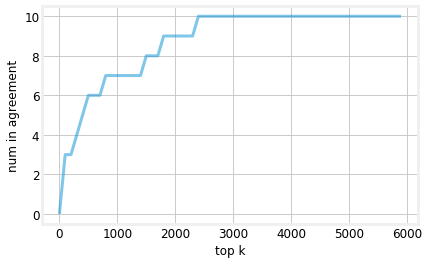

In [119]:
preds_sgd = preds_full_train[('sgd', 5)].detach().numpy()
preds_adam = preds_full_train[('adam', 4)].detach().numpy()
inds_sgd = np.argsort(preds_sgd, axis=0)
inds_adam = np.argsort(preds_adam, axis=0)

nums_agree = []
ks = np.arange(1, 6000, 100)
for k in ks:
    nums_agree.append(stats.num_agree_topk(inds_adam, inds_sgd, k=k))
plt.plot(ks, nums_agree)
plt.xlabel('top k')
plt.ylabel('num in agreement')
plt.show()

### intra-class correlations?
**intra-class correlations are important only for the predictions of that class**

mean: 0.28, [0.7047645910728625, 0.1464318596195675, 0.31353115084115585, 0.46888738537910424, -0.061823578002368096, -0.21233438720797465, 0.1608867871242554, 0.6472906666164053, 0.19314482597157212, 0.4723171934636626]


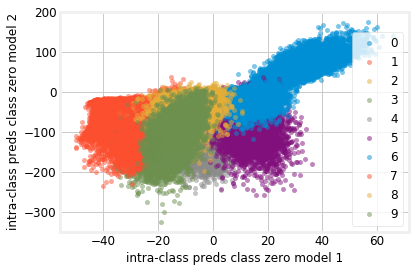

In [91]:
for lab_num in range(10):
    plt.plot(preds_sgd[Y_train==lab_num][:, 0], 
             preds_adam[Y_train==lab_num][:, 0], '.', alpha=0.5, label=str(lab_num))
plt.legend()
plt.xlabel('intra-class preds class zero model 1')
plt.ylabel('intra-class preds class zero model 2')
corrs = []
for lab_num in range(10):
    corrs.append(np.corrcoef(preds_sgd[Y_train==lab_num][:, 0], preds_adam[Y_train==lab_num][:, 0])[0, 1])
print(f'mean: {np.mean(corrs):.2f}, {corrs}')
plt.tight_layout()
plt.savefig('intra_class_preds_class=0.png', dpi=300)

**intra-class predictions within a class are pretty high**

mean: 0.62, [0.7047645910728625, 0.42461292251471355, 0.7194073115527755, 0.7881887923137852, 0.6417180754546032, 0.7801593646480522, 0.6068702932558263, 0.38365066763699135, 0.7095104924604062, 0.4840452387282613]


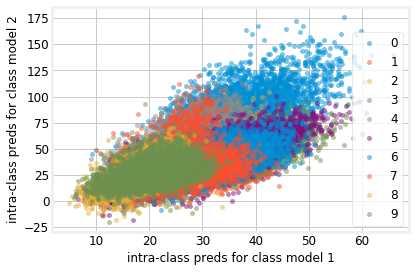

In [90]:
for lab_num in range(10):
    plt.plot(preds_sgd[Y_train==lab_num][:, lab_num], 
             preds_adam[Y_train==lab_num][:, lab_num], '.', alpha=0.5, label=str(lab_num))
plt.legend()
plt.xlabel('intra-class preds for class model 1')
plt.ylabel('intra-class preds for class model 2')
corrs = []
for lab_num in range(10):
    corrs.append(np.corrcoef(preds_sgd[Y_train==lab_num][:, lab_num], preds_adam[Y_train==lab_num][:, lab_num])[0, 1])
print(f'mean: {np.mean(corrs):.2f}, {corrs}')
plt.tight_layout()
plt.savefig('intra_class_preds.png', dpi=300)

# prune by magnitude, see if acc goes down

In [ ]:
# takes in weights_dict copy
# zeros the k weights with the smallest norms
# returns new weights dict
def zero_top_k(weights_dict, k=1, lay='fc.0.weight'):
    w_orig = deepcopy(weights_dict[lay])
    if k > 0:
        norms = np.linalg.norm(w_orig, axis=1)
        idxs_smallest = np.argsort(norms)[:k]
        w_orig[idxs_smallest] = 0 * w_orig[idxs_smallest]
    weights_dict_copy = deepcopy(weights_dict)
    weights_dict_copy[lay] = w_orig
    return weights_dict_copy

accs_train = {'sgd': [], 'adam': []}
accs_test = {'sgd': [], 'adam': []}
device = 'cpu'
for run in [rw_sgd, rw_adam]:
    print(run.optimizer)
        
    # get data
    train_loader, test_loader = data.get_data_loaders(run)
    X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader, device=device)
    
    # load in weights
    model = data.get_model(run)
    weights_dict_dict = run['weights'] # keys are epochs, vals are dicts of all weights
    weights_dict = weights_dict_dict[epoch] # keys are layers, vals are weight values    

    # prune 1st lay weights by magnitude and see how acc changes    
    for k in tqdm(range(512)):
        weights_dict_copy = zero_top_k(weights_dict, k=k)
        weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict_copy.items()}
        model.load_state_dict(weights_dict_tensors)
        model = model.to(device)
        acc_train, acc_test = stats.calc_accs(model, X_train, Y_train, X_test, Y_test)
        accs_train[run.optimizer].append(acc_train)
        accs_test[run.optimizer].append(acc_test)         

sgd


 18%|█▊        | 93/512 [08:43<39:55,  5.72s/it]

In [ ]:
plt.subplot(121)
plt.ylabel('Training accuracy')
plt.plot(np.arange(512) / 512 * 100, accs_train['sgd'], label='sgd')
plt.plot(np.arange(512) / 512 * 100, accs_train['adam'], label='adam')
plt.xlabel('Percent of layer 1 filters pruned')
# plt.legend()

plt.subplot(122)
plt.ylabel('Testing accuracy')
plt.plot(np.arange(512) / 512 * 100, accs_test['sgd'], label='sgd')
plt.plot(np.arange(512) / 512 * 100, accs_test['adam'], label='adam')
plt.xlabel('Percent of layer 1 filters pruned')
plt.legend()

plt.tight_layout()
plt.savefig('pruning.pdf')
plt.show()

# norms vs mem

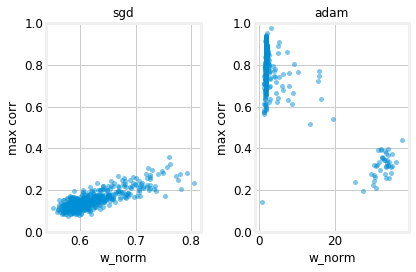

In [15]:
tmax = max(ts)

plt.subplot(121)
r_sgd = r[r.optimizer == 'sgd'].iloc[0]
d = r_sgd['mean_max_corrs'][tmax]['fc.0.weight']
plt.plot(d['W_norms'], d['max_corrs'], '.')
plt.xlabel('w_norm')
plt.ylabel('max corr')
plt.ylim(0, 1)
plt.title('sgd')

plt.subplot(122)
r_adam = r[r.optimizer == 'adam'].iloc[0]
d = r_adam['mean_max_corrs'][tmax]['fc.0.weight']
plt.plot(d['W_norms'], d['max_corrs'], '.')
plt.xlabel('w_norm')
plt.ylabel('max corr')
plt.title('adam')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('corr_vs_norm.pdf')
plt.show()

**norm cdfs**

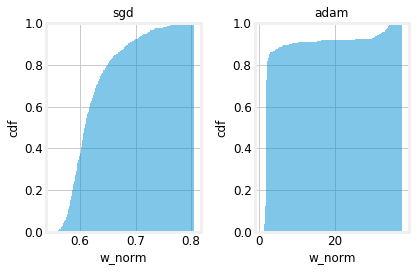

In [16]:
tmax = max(ts)

plt.subplot(121)
r_sgd = r[r.optimizer == 'sgd'].iloc[0]
d = r_sgd['mean_max_corrs'][tmax]['fc.0.weight']
plt.hist(d['W_norms'], cumulative=True, normed=True, bins=512)
plt.xlabel('w_norm')
plt.ylabel('cdf')
plt.ylim(0, 1)
plt.title('sgd')

plt.subplot(122)
r_adam = r[r.optimizer == 'adam'].iloc[0]
d = r_adam['mean_max_corrs'][tmax]['fc.0.weight']
plt.hist(d['W_norms'], cumulative=True, normed=True, bins=512)
plt.xlabel('w_norm')
plt.ylabel('cdf')
plt.title('adam')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('corr_cdf.pdf')
plt.show()

# predict on just noise

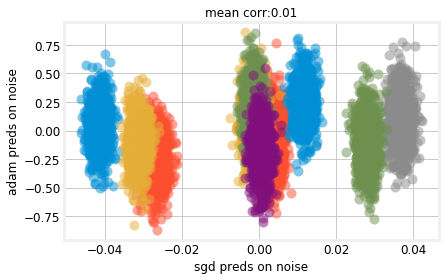

In [121]:
preds = {}
for run in [rw_sgd, rw_adam]:
        
    # get data
    X = torch.randn(1000, 1, 28, 28)
    
    # load in weights
    model = data.get_model(run)
    weights_dict_dict = run['weights'] # keys are epochs, vals are dicts of all weights
    weights_dict = weights_dict_dict[epoch] # keys are layers, vals are weight values    
    preds[run.optimizer] = model(X).cpu().detach().numpy()
    
plt.plot(preds['sgd'], preds['adam'], 'o')
plt.xlabel('sgd preds on noise')
plt.ylabel('adam preds on noise')
plt.title (f'mean corr:{stats.calc_mean_corr(preds["sgd"], preds["adam"]):.2f}')
plt.show()